In [172]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(12,8)})

import warnings 
warnings.filterwarnings('ignore')

In [2]:
hcl_data = pd.read_csv('HCLTECH.csv')
hcl_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-11,HCLTECH,EQ,580.00,1550.0,1725.00,1492.00,1560.00,1554.45,1582.72,1192200,1.886915e+14,NaN,NaN,NaN
1,2000-01-12,HCLTECH,EQ,1554.45,1560.0,1678.85,1560.00,1678.85,1678.85,1657.05,344850,5.714349e+13,NaN,NaN,NaN
2,2000-01-13,HCLTECH,EQ,1678.85,1790.0,1813.20,1781.00,1813.20,1813.20,1804.69,53000,9.564880e+12,NaN,NaN,NaN
3,2000-01-14,HCLTECH,EQ,1813.20,1958.3,1958.30,1835.00,1958.30,1958.30,1939.90,270950,5.256169e+13,NaN,NaN,NaN
4,2000-01-17,HCLTECH,EQ,1958.30,2115.0,2115.00,1801.65,1801.65,1801.65,1990.55,428800,8.535473e+13,NaN,NaN,NaN


In [9]:
ts = hcl_data[['Date','Prev Close']]
ts.index = pd.to_datetime(ts.Date)
ts = ts.drop(['Date'],axis=1)
ts = ts.rename(columns={'Prev Close':'values'})

In [19]:
ts.tail()

,values
Date,
2021-04-26,955.65
2021-04-27,928.80
2021-04-28,928.85
2021-04-29,923.80
2021-04-30,909.55


In [102]:
#taking test ['2020-04-30':'2021-04-30']
#taking train data of only one year ['2019-04-30':'2020-04-30']
train = ts['2019-04-30':'2020-04-30']
test = ts['2020-04-30':'2021-04-30']


<AxesSubplot:xlabel='Date'>

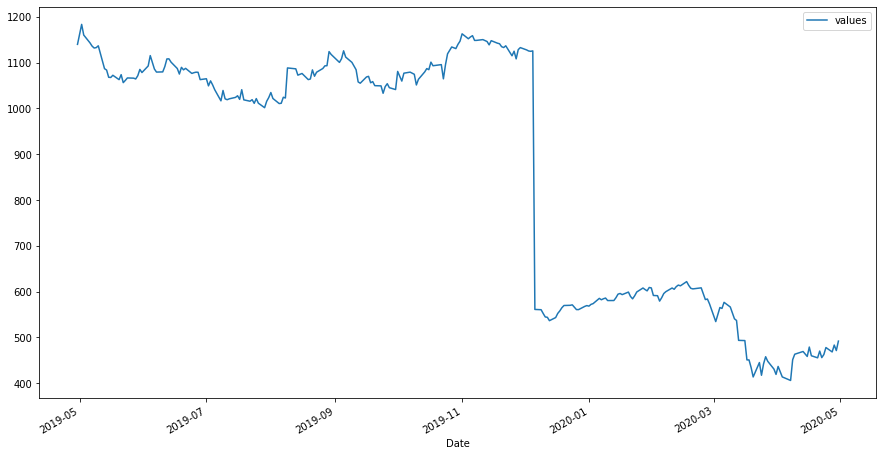

In [105]:
train.plot() 

## checking data is stationary or not
1. decompose
2. rolling average
3. adfuller test

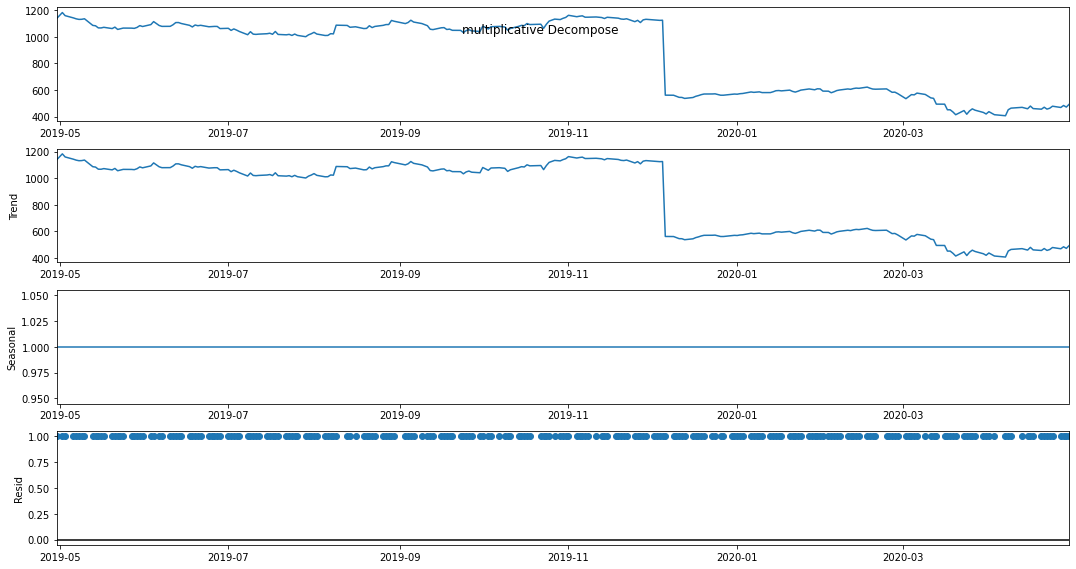

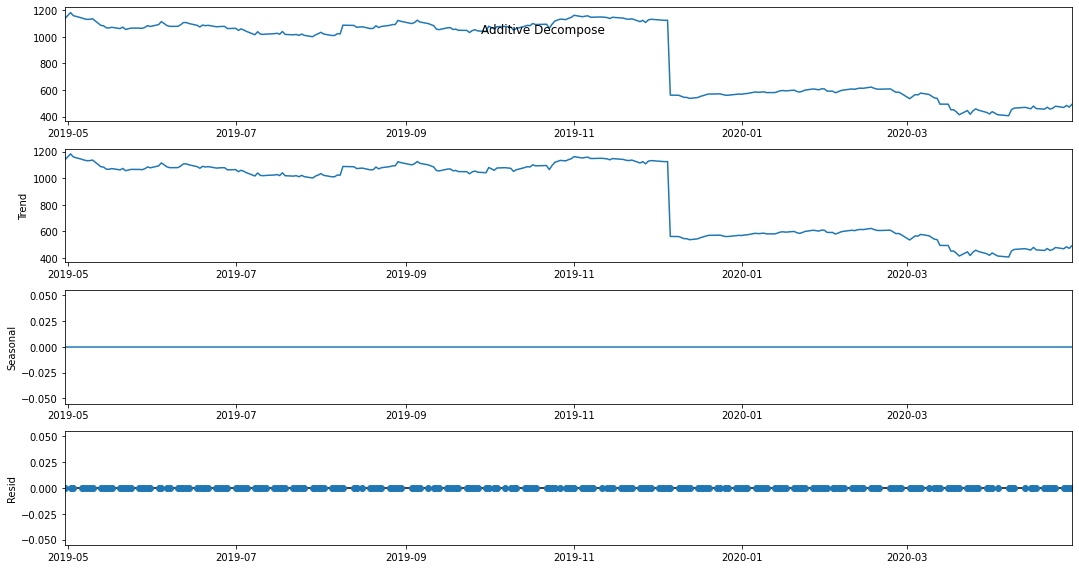

In [121]:
## decomposing the data
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(data):
    #['2013-01-01':'2013-12-01']
    decompose_mul = seasonal_decompose(data,model='multiplicative',period=1)
    decompose_mul.plot().suptitle('\nmultiplicative Decompose', fontsize=12)

    decompose_add = seasonal_decompose(data,model='additive',period=1)
    decompose_add.plot().suptitle('\nAdditive Decompose', fontsize=12)

decompose(train)

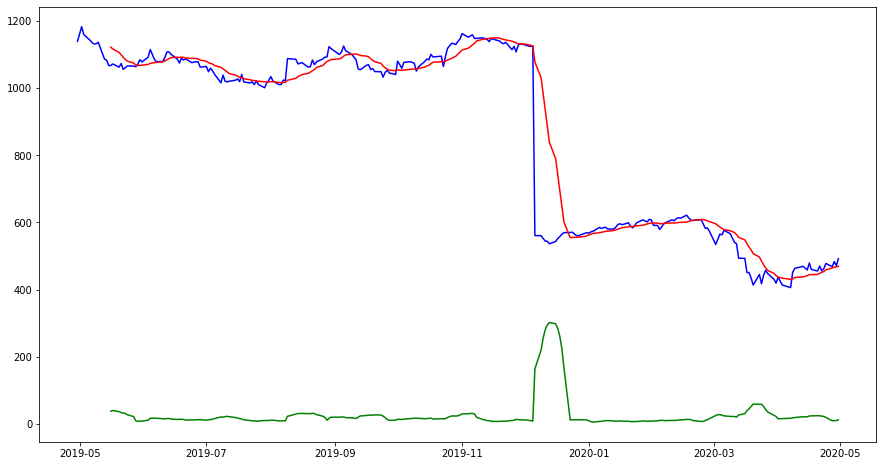

In [114]:
def rolling_average(data):
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()

    plt.plot(data,color='blue')
    plt.plot(rolling_mean,color='red')
    plt.plot(rolling_std,color='green')

rolling_average(train)

In [110]:
## adfuller test
## null hypothesis - not statioary - if p-value < 0.05 reject the null hypothesis
from statsmodels.tsa.stattools import adfuller


def adfuller_test(data):
    adfuller_result = adfuller(data)

    print(f'ADF statistics: {adfuller_result[0]}')
    print(f"p_value : {adfuller_result[1]}")

    for key,value in adfuller_result[4].items():
        print('Critical values')
        print(f"{key}:{value}")

    if adfuller_result[1] > 0.05 :
        print('accept the null hypothesis - data is not stationary')
    else:
        print('reject the null hypothesis - data is stationary')
        
adfuller_test(train)

ADF statistics: -0.9210177699721678
p_value : 0.7809721943613881
Critical values
1%:-3.457215237265747
Critical values
5%:-2.873361841566324
Critical values
10%:-2.5730700760129555
accept the null hypothesis - data is not stationary


## making series stationary
1. log transformation
2. creating a differenced time series : shift the time series by one and substract by orginal series

ADF statistics: -0.8142414095634727
p_value : 0.814902926026434
Critical values
1%:-3.457215237265747
Critical values
5%:-2.873361841566324
Critical values
10%:-2.5730700760129555
accept the null hypothesis - data is not stationary


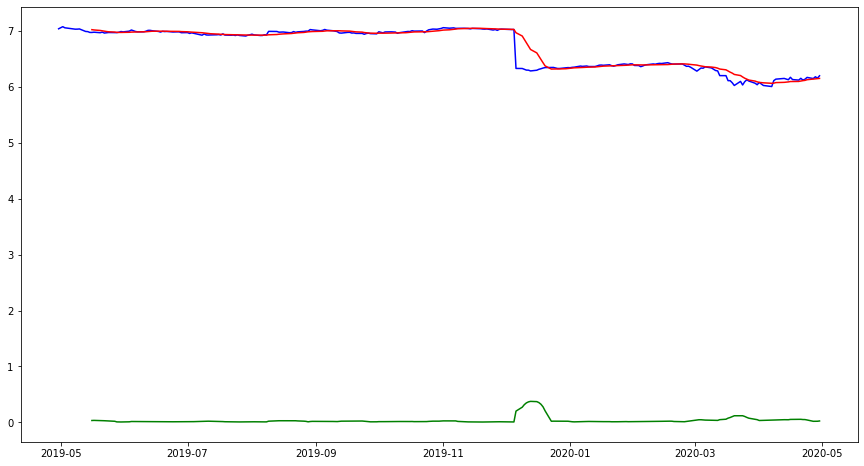

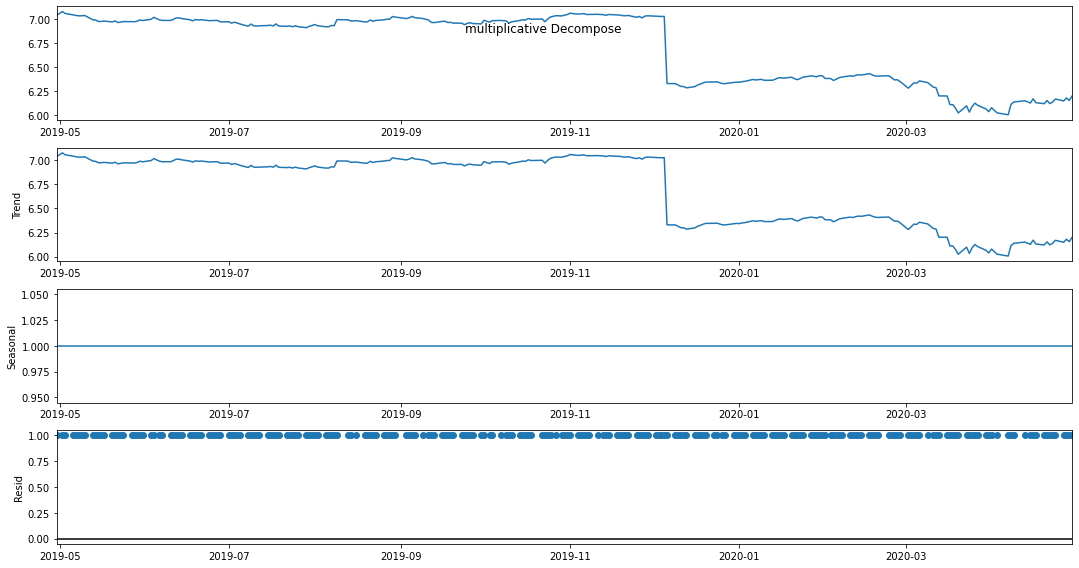

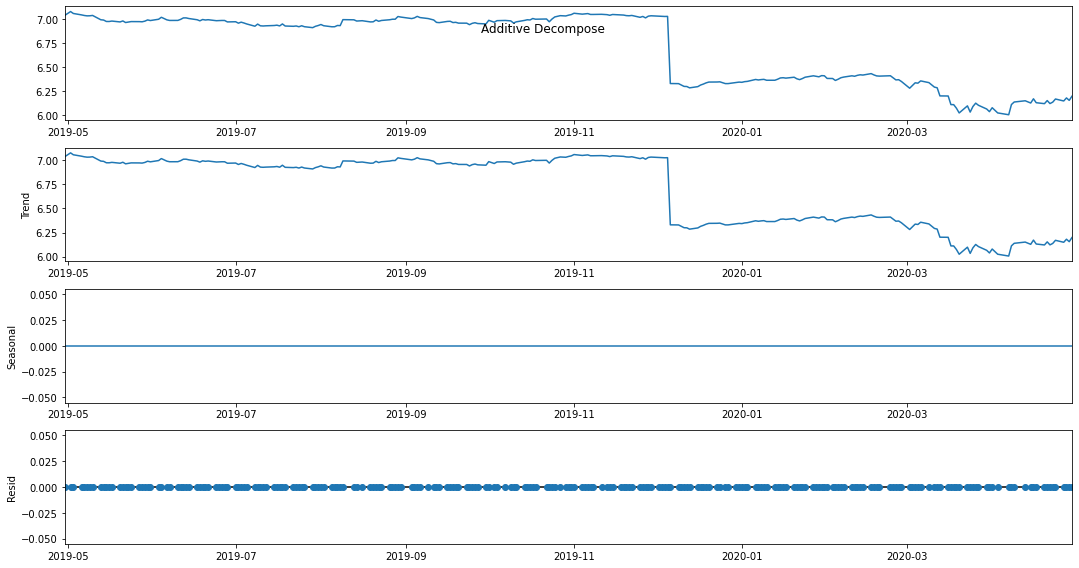

In [127]:
# log trainsformation
import numpy as np

train_log = np.log(train)

# ploting rolling average , ecompose and adfuler test of log series
rolling_average(train_log)
adfuller_test(train_log)
decompose(train_log)

ADF statistics: -4.155031266841466
p_value : 0.0007844057556677537
Critical values
1%:-3.4586084859607156
Critical values
5%:-2.873972159235721
Critical values
10%:-2.57339565928848
reject the null hypothesis - data is stationary


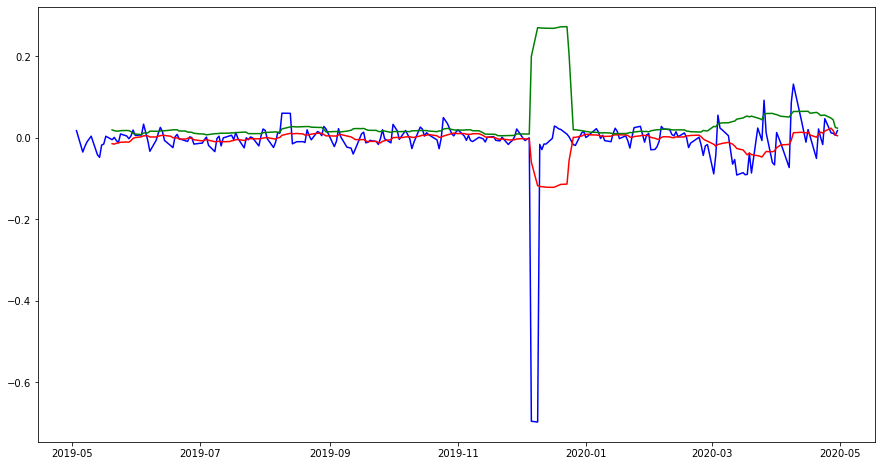

In [143]:
### differenced time series
train_log_diff = train_log - train_log.shift(2)

# ploting rolling average , ecompose and adfuler test of log series
rolling_average(train_log_diff)
adfuller_test(train_log_diff.dropna())
#decompose(train_log_diff.dropna())

In [1]:
from statsmodels.tsa.stattools import acf,pacf

# helps us to find the AR and MA value
lag_acf = acf(train_log_diff.dropna() ,nlags=20)  # for moving average
lag_pacf = pacf(train_log_diff.dropna() ,nlags=20) # for AutoRegressor

NameError: name 'train_log_diff' is not defined

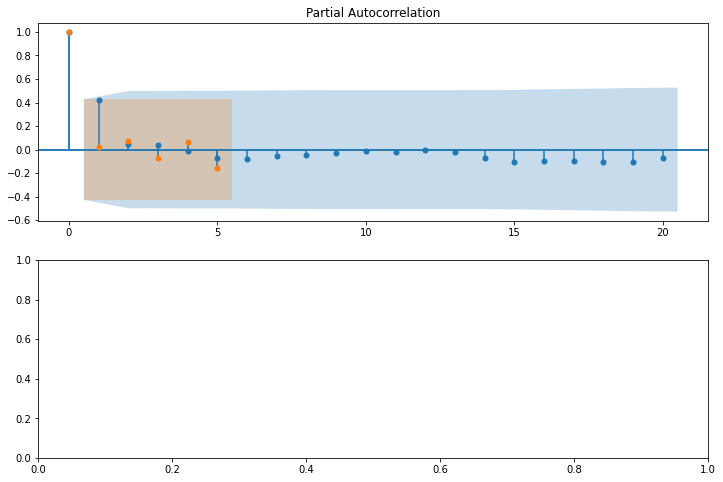

In [180]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(lag_acf, lags=20 , ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(lag_pacf, lags=5 , ax=ax1)

In [196]:
## ARIMA model using p = 3 , d= 0 , q = 3

from statsmodels.tsa.arima_model import ARIMA

ARIMA_model = ARIMA(train_log_diff.dropna() , order=(2,0,2))
ARIMA_result = ARIMA_model.fit()


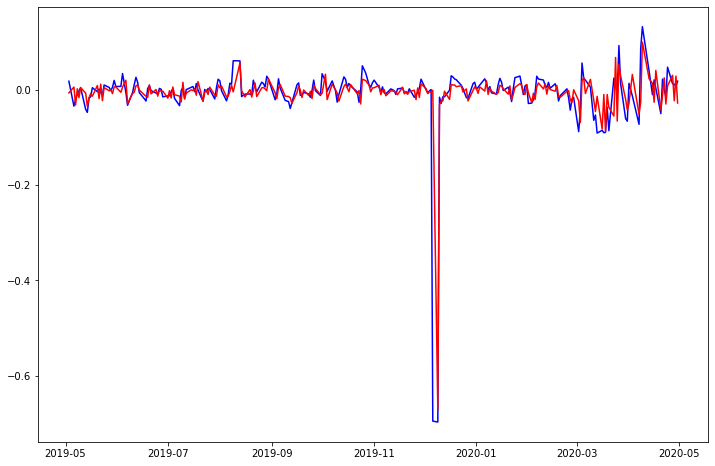

In [197]:
plt.plot(train_log_diff , color='blue')
plt.plot(ARIMA_result.fittedvalues , color='red')

In [288]:
## we have done transformation so we revert data back
# taking result back to original scale
ARIMA_diff_predication = pd.Series(ARIMA_result.fittedvalues , copy=True)
ARIMA_diff_predication

Date
2019-05-03   -0.006835
2019-05-06    0.005383
2019-05-07   -0.032252
2019-05-08    0.001785
2019-05-09   -0.016858
                ...   
2020-04-24    0.007942
2020-04-27    0.030050
2020-04-28   -0.023448
2020-04-29    0.028389
2020-04-30   -0.028101
Length: 245, dtype: float64

In [266]:
# taking cumulative sum because we differenced the time series
ARIMA_diff_predication_cumsum = ARIMA_diff_predication.cumsum()
ARIMA_diff_predication_cumsum

Date
2019-05-03   -0.006835
2019-05-06   -0.001452
2019-05-07   -0.033704
2019-05-08   -0.031919
2019-05-09   -0.048777
                ...   
2020-04-24   -1.750130
2020-04-27   -1.720080
2020-04-28   -1.743528
2020-04-29   -1.715138
2020-04-30   -1.743239
Length: 245, dtype: float64

In [284]:
### taking top two values because we shift 2 and adding the top of cumsum values so shape will be maintained
ARIMA_log_predication = ARIMA_diff_predication_cumsum.copy()
ARIMA_log_predication = pd.Series(ARIMA_log_predication,index=train_log.index)
ARIMA_log_predication[0] = train_log['values'][0]
ARIMA_log_predication[1] = train_log['values'][1]
ARIMA_log_predication.head()

Date
2019-04-30    7.038564
2019-05-02    7.076105
2019-05-03   -0.006835
2019-05-06   -0.001452
2019-05-07   -0.033704
dtype: float64

In [285]:
## because we do log so taking exponential
ARIMA_log_predication = np.exp(ARIMA_log_predication)

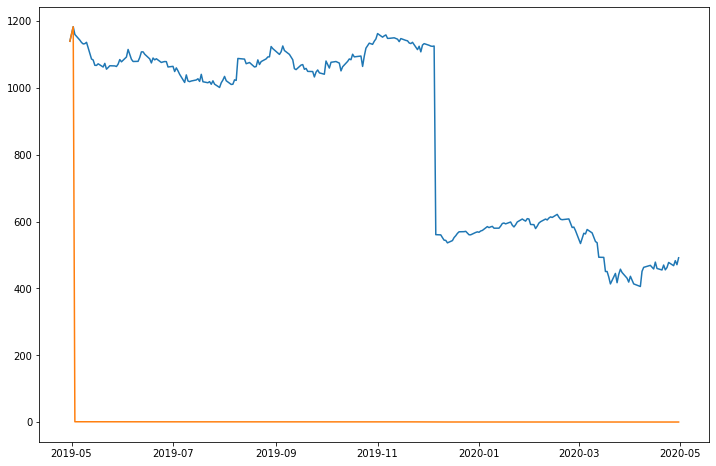

In [287]:
plt.plot(train)
plt.plot(ARIMA_log_predication)

In [300]:
#test = ts['2020-04-30':'2021-04-30']
#len(train) #5050 tk data hai  4800 - 5050 tk train hai
#len(ts)-5050 # 250 baki hai

y_pred = ARIMA_result.predict(,, typ='levels')

ValueError: Length of values (4805) does not match length of index (250)

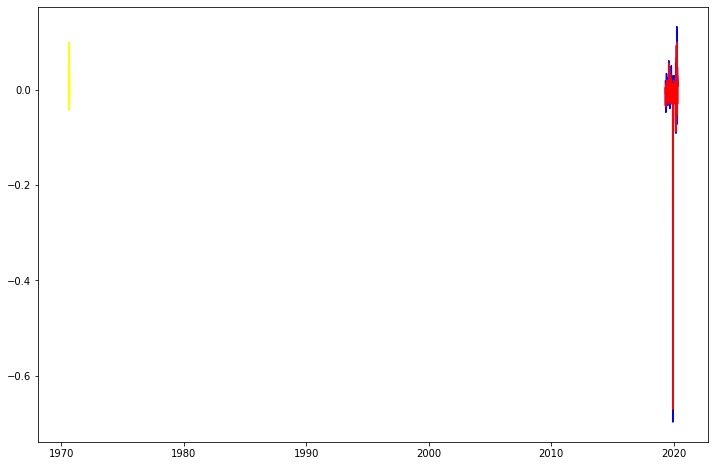

In [298]:
plt.plot(train_log_diff , color='blue')
plt.plot(ARIMA_result.fittedvalues , color='red')
plt.plot(y_pred , color='yellow')